In [1]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf
abs_config_dir = os.path.abspath("config/")

with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config = compose(config_name="test_hartmann.yaml", overrides=[])
    print(OmegaConf.to_yaml(config))
    print(config)

config.sampler.conf.logger.do.online = False

dataset:
  grid_size: 10
  normalize_scores: true
  train_fraction: 1.0
  batch_size: 16384
  shuffle: true
  train_path: ~/activelearning/my_package/storage/hartmann/data_train.csv
  test_path: null
  _target_: activelearning.dataset.grid.HartmannDatasetHandler
oracle:
  _target_: activelearning.oracle.oracle.Hartmann
  fidelity: 1
  do_domain_map: true
selector:
  _target_: activelearning.filter.filter.ScoreFilter
sampler:
  _target_: activelearning.sampler.sampler.RandomSampler
  conf:
    agent:
      random_action_prob: 0.001
      optimizer:
        lr: 0.0005
        n_train_steps: 5000
    logger:
      do:
        online: true
      project_name: test_hartmann_gflownet
      run_name: identity_lr5e-4 newdata
    env:
      length: 10
      n_dim: 6
      cell_min: 0
      cell_max: 0.99
      reward_func: power
      reward_min: 1.0e-08
      reward_beta: 1.0
      reward_norm: 1.0
surrogate:
  _target_: activelearning.surrogate.surrogate.SurrogatePipeline
  acq_fn:
    _targe

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'test_hartmann.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [2]:
import torch
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = config.device
n_iterations = config.budget  # TODO: replace with budget
grid_size = config.dataset.grid_size
n_samples = config.n_samples
maximize = config.maximize

from gflownet.utils.common import set_float_precision
float_prec = set_float_precision(config.float_precision)

import matplotlib.colors as cm
import matplotlib.pyplot as plt
# colors = ["red", "blue", "green", "orange", "brown", "pink"]
colors = plt.get_cmap("Reds")

In [3]:
from activelearning.dataset.grid import HartmannDatasetHandler
from activelearning.utils.logger import WandBLogger
from activelearning.utils.plotter import ProjectionPlotHelper


# Dataset
dataset_handler = HartmannDatasetHandler(
    grid_size=grid_size,
    train_path="./data/hartmann/data_train.csv",
    train_fraction=1.0,
    float_precision=float_prec,
)
candidate_set, xi, yi = dataset_handler.get_candidate_set(step=1, as_dataloader=True)
plot_set, _, _ = dataset_handler.get_candidate_set(step=2, as_dataloader=False)

# logger = WandBLogger(project_name="test_hartmann_plots", run_name="RandomSampler RandomFilter")
logger = None

# plotter = None
# plotter = ProjectionPlotHelper(plot_set[:], logger)
plotter = ProjectionPlotHelper(plot_set[:])
# plotter.logger = logger

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can

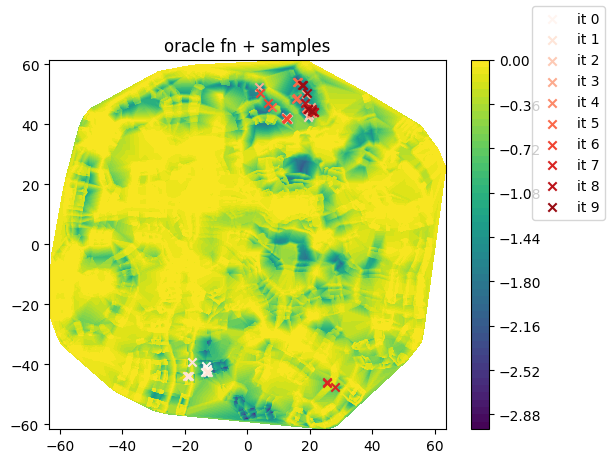

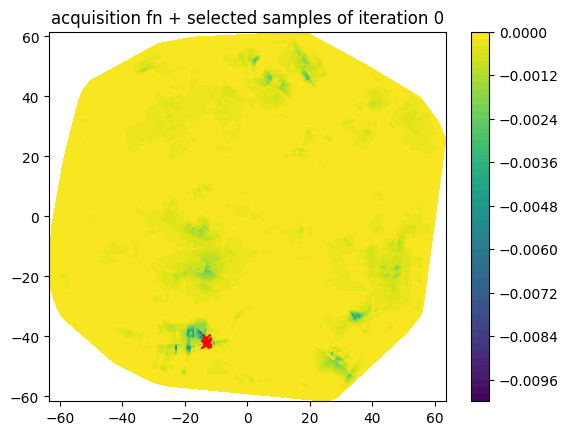

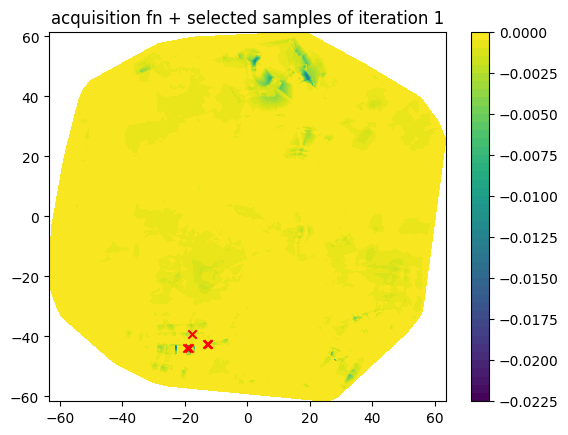

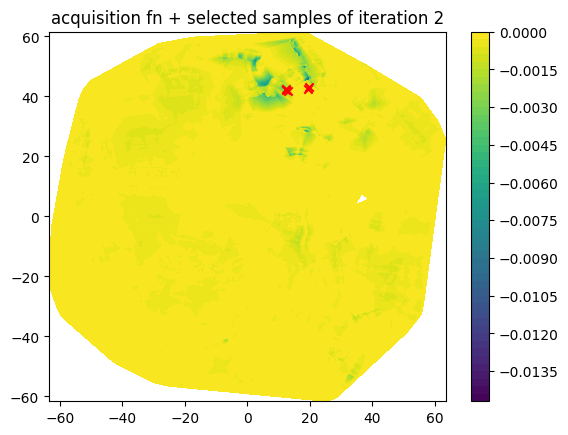

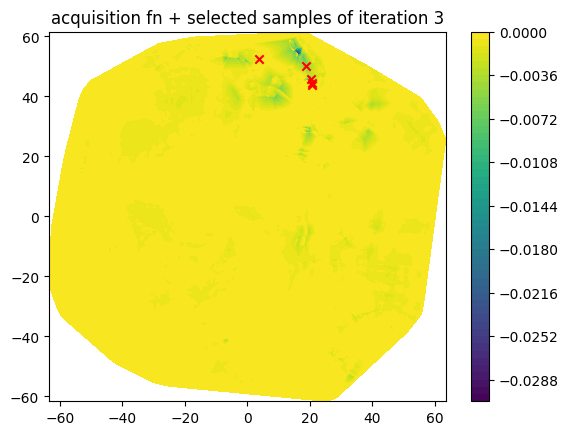

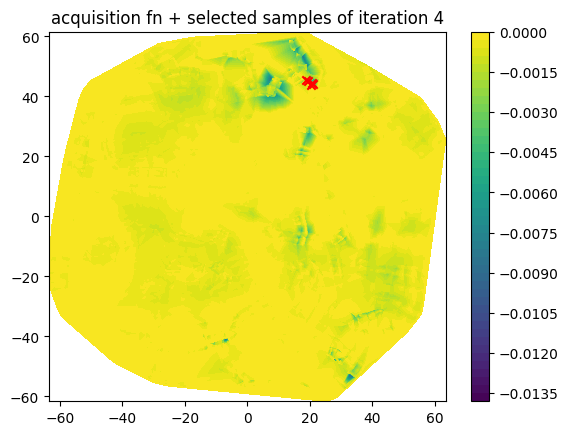

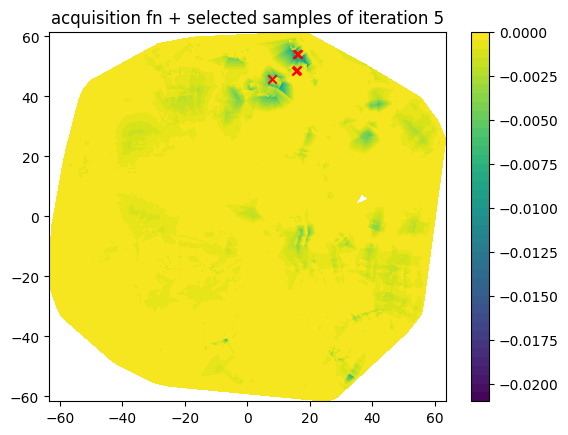

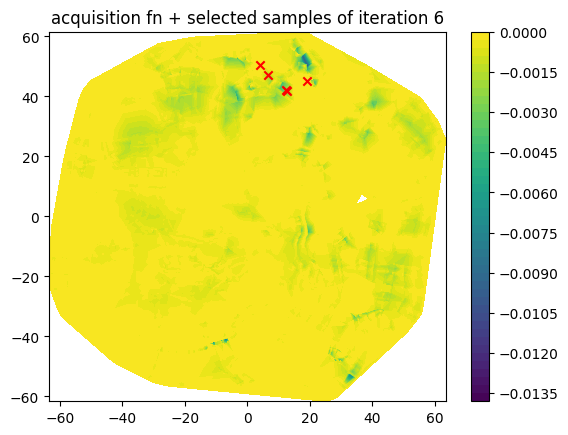

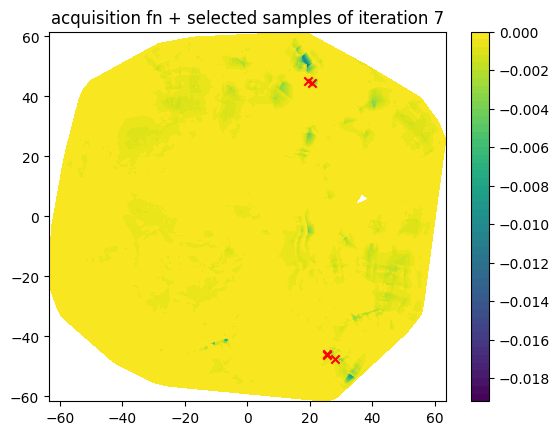

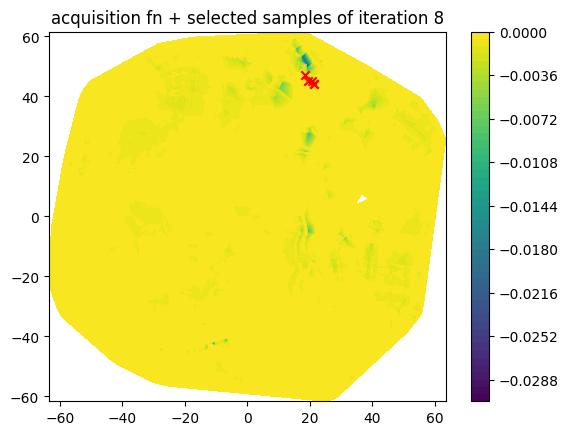

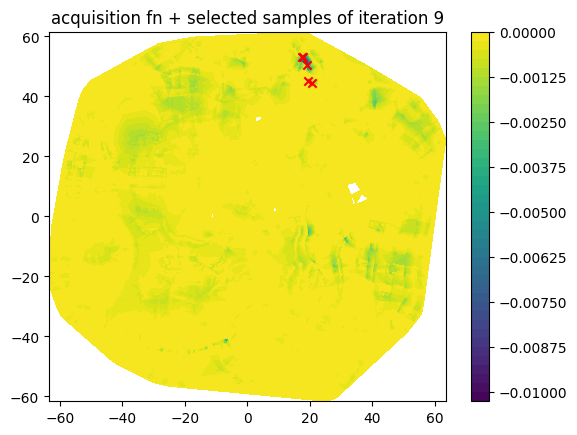

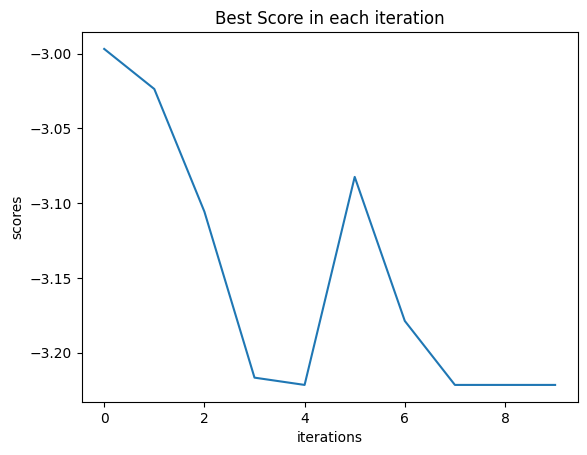

In [5]:
from activelearning.surrogate.gp_surrogate import SingleTaskGPRegressor
from activelearning.surrogate.surrogate import SurrogatePipeline
from activelearning.surrogate.acquisition.acquisition import BOTorchAcqHandler
from activelearning.sampler.sampler import GreedySampler, RandomSampler
from activelearning.selector.selector import Selector, ScoreSelector
from activelearning.oracle.oracle import HartmannOracle

# Oracle
oracle = HartmannOracle(fidelity=1, device=device, float_precision=float_prec)

if plotter is not None:
    fig_oracle, ax_oracle = plotter.plot_function(oracle)


best_scores = []

for i in range(n_iterations):

    train_data, test_data = dataset_handler.get_dataloader()
    # print("iteration", i)
    # Surrogate (e.g., Bayesian Optimization)
    # starts with a clean slate each iteration
    surrogate_model = SingleTaskGPRegressor(
        device=device,
        float_precision=float_prec,
        maximize=maximize,
    )
    acq_fn = BOTorchAcqHandler("qLowerBoundMaxValueEntropy")
    surrogate = SurrogatePipeline(
        acq_fn,
        surrogate_model,
        device=device,
        float_precision=float_prec,
        maximize=maximize,
    )
    surrogate.fit(train_data)

    # Sampler (e.g., GFlowNet, or Random Sampler)
    # also starts with a clean slate; TODO: experiment with NOT training from scratch
    # sampler = RandomSampler(
    #     surrogate,
    # )
    sampler = GreedySampler(
        surrogate,
        device=device,
        float_precision=float_prec,
    )
    # sampler = hydra.utils.instantiate(
    #     config.sampler,
    #     surrogate=surrogate,
    #     device=device,
    #     float_precision=float_prec,
    #     _recursive_=False,
    # )

    sampler.fit()  # only necessary for samplers that train a model

    samples = sampler.get_samples(n_samples * 5, candidate_set=candidate_set)

    if plotter is not None and hasattr(sampler, "sampler"):

        def reward_fn(samples):
            return sampler.sampler.env.proxy2reward(sampler.sampler.env.proxy(samples))

        fig_reward, ax_reward = plotter.plot_function(reward_fn)
        fig_reward, ax_reward = plotter.plot_samples(samples, ax_reward, fig_reward)
        ax_reward.set_title("reward fn + proposed samples of iteration %i" % i)
        plotter.log_figure(fig_reward, "reward")

    # Selector
    # selector = Selector()
    selector = ScoreSelector(
        surrogate.get_acquisition_values,
        device=device,
        float_precision=float_prec,
    )
    filtered_samples = selector(n_samples=n_samples, candidate_set=samples.clone())

    if plotter is not None:
        fig_acq, ax_acq = plotter.plot_function(surrogate)
        fig_acq, ax_acq = plotter.plot_samples(filtered_samples, ax_acq, fig_acq)
        ax_acq.set_title("acquisition fn + selected samples of iteration %i" % i)
        plotter.log_figure(fig_acq, "acq")

    if plotter is not None:
        fig_acq, ax_acq = plotter.plot_samples(
            filtered_samples,
            ax_oracle,
            fig_oracle,
            c=cm.to_hex(colors(i / n_iterations)),
            label="it %i" % i,
        )

    del surrogate
    del sampler
    del selector

    scores = oracle(filtered_samples.clone())
    dataset_handler.update_dataset(filtered_samples.cpu(), scores.cpu())
    best_scores.append(scores.min().cpu())
    if logger is not None:
        logger.log_metric(scores.min().cpu(), "best_score")

if plotter is not None:
    fig_oracle.legend()
    ax_oracle.set_title("oracle fn + samples")
    plotter.log_figure(fig_oracle, key="oracle")


fig = plt.figure()
plt.plot(best_scores)
plt.xlabel("iterations")
plt.ylabel("scores")
plt.title("Best Score in each iteration")
if plotter is not None:
    plotter.log_figure(fig, key="best_scores")